# Домашнее задание 5. Линейные модели

In [49]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from __future__ import division
from sklearn.metrics import roc_auc_score, roc_curve 
from numpy.random import choice
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from statsmodels.sandbox.stats.multicomp import multipletests
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [50]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [51]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [52]:
# TODO check this code
# Actually it doesn't work unless order of users in out_4 and df_users is the same
# I make hw4 to return table with the same order of users



train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]


In [53]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x345824) feature matrix, 7199 target vector


Уравняем число пользователей двух классов для обучения. 

In [54]:
sample_size = int(min( (Y == 0).sum(), (Y == 1).sum()))

X1 = X.tocsc()

Y0 = Y[Y == 0]
Y1 = Y[Y == 1]


to_take = np.random.permutation(np.arange(Y0.shape[0]))[0:sample_size]
Y0 = Y0[to_take]
X_0 = X1[Y == 0]
X_0 = X_0[to_take]
    


to_take = np.random.permutation(np.arange(Y1.shape[0]))[0:sample_size]

Y1 = Y1[to_take]
X_1 = X1[Y == 1]
X_1 = X_1[to_take]


X1 = np.concatenate([X_1.toarray(), X_0.toarray()])
Y = np.concatenate([Y1, Y0])

#print X1.shape
#print Y.shape
#print sample_size

Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

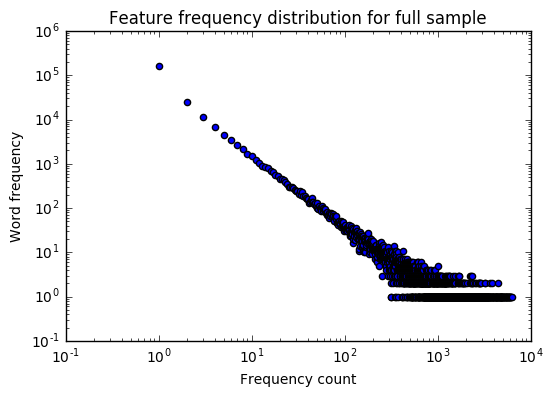

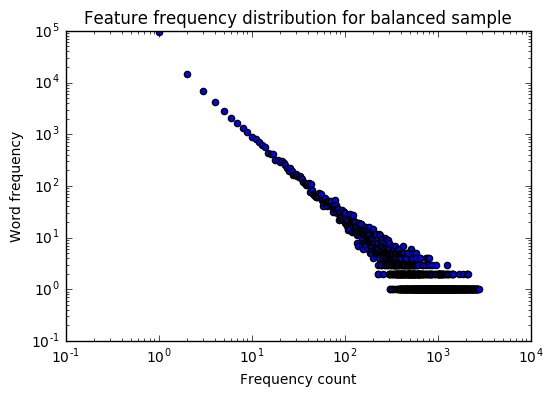

In [55]:
from collections import defaultdict
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    counts =  np.array((x != 0).sum(axis = 0)).squeeze()
    counts = counts[counts != 0]
    rank = counts.shape[0] - rankdata(counts) + 1

    y = np.bincount(counts)
    ii = np.nonzero(y)[0]
    result = zip(ii,y[ii])

    wordfreqslist = list(zip(*result)[0])
    freqscountlist = list(zip(*result)[1])

    pl.scatter(wordfreqslist, freqscountlist)
    plt.xlabel("Frequency count")
    plt.ylabel("Word frequency")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    return np.array((x != 0).sum(axis = 0)).squeeze()

plt.title("Feature frequency distribution for full sample")
features_counts = draw_log_hist(X)



plt.title("Feature frequency distribution for balanced sample")
features_counts = draw_log_hist(X1)

Видим, что данные приблизительно соответствуют закону Ципфа, хотя часть из него выбивается

In [56]:
X2 = X1.copy()

In [57]:
X1 = X2[:,features_counts > 200]

Вариант задания генерируется на основании вашего ника в техносфере.

In [58]:
USER_NAME = "d.penzar"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [59]:
def auroc(y_prob, y_true, step = 0.001):
    one_minus_specificity_arr = []
    sensitivity_arr = []
    area = 0
    for x in xrange(0, int(1 / step) + 3):
        thres = 1 - step * (x - 1)
        y_predict = y_prob >= thres
        
        true_pos = np.sum(np.logical_and(y_predict == 1, y_true == 1))
        false_pos = np.sum(y_predict == 1) - true_pos
        
        true_neg = np.sum(np.logical_and(y_predict == 0, y_true == 0))
        false_neg = (y_predict == 0).sum() - true_neg
        
        
        
        sensitivity_arr.append(true_pos / (true_pos + false_neg +  + 0.0001))
        
        one_minus_specificity_arr.append( false_pos / (false_pos + true_neg +  + 0.0001))
        
        if x > 0:
            area += (one_minus_specificity_arr[x] - one_minus_specificity_arr[x - 1]) *\
                ( (sensitivity_arr[x] - sensitivity_arr[x - 1]) / 2 + sensitivity_arr[x - 1])
        
    return  sensitivity_arr, one_minus_specificity_arr, area

Реализуем выбранный алгоритм

In [67]:
class LogisticRegression(object):
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    @staticmethod
    def compute_cost(X, Y, theta, C): 
        J = np.mean(- Y * np.log(LogisticRegression.sigmoid(np.dot(X, theta)) + 1e-15)\
                    - (1 - Y) * np.log(1 - LogisticRegression.sigmoid(np.dot(X, theta)) + 1e-15))\
                    + C / X.shape[0] * np.abs(theta).sum()
        return J
    @staticmethod
    def cost_function_gradient (X, Y, theta, C):
        gradient = np.mean((LogisticRegression.sigmoid(np.dot(X, theta)) - Y) * X.T, axis = 1)\
            + np.sign(theta) * C / X.shape[0]
        return gradient

    
    @staticmethod
    def stochastic_gradient(X, Y, theta, alpha, C, eps = 0.04, max_it = 10):
        cur_it = 0
        while cur_it < max_it:
            cur_it += 1
            for i in np.random.permutation(theta.shape[0]):
                new_theta = theta - alpha  * ( C * np.sign(theta[i]) +\
                            np.dot((LogisticRegression.sigmoid(np.dot(X[:, i], theta[i])) - Y) , X[:, i])) / X.shape[0] 
                if np.linalg.norm(new_theta - theta) > eps:
                    return new_theta
                else:
                    #print np.linalg.norm(new_theta - theta)
                    theta = new_theta
        print np.linalg.norm(new_theta - theta) 
        print "Don't find"
        return theta
            
            
        
    @staticmethod
    def gradient_descent(self, alpha, X, Y, eps, max_iter, validation_size, max_validate_diff):
        
        X = np.hstack([X, np.ones( (X.shape[0], 1))])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = validation_size)
        #Y = np.array(Y)

        theta = np.random.normal(size = X.shape[1])
        theta_arr = list()
        theta_arr.append(theta)
        prev_cost_function_train_value = self.compute_cost(X_train, Y_train, theta, self.C)
        prev_cost_function_validate_value = self.compute_cost(X_test, Y_test, theta, self.C)
        
        cost_function_train  = list()
        cost_function_train.append(prev_cost_function_train_value)
        cost_function_validate = list()
        cost_function_validate.append(prev_cost_function_validate_value)
        
        for i in xrange(0, max_iter):
            if self.use_stochastic:
                new_theta = self.stochastic_gradient(X, Y, theta, alpha, self.C)
            else:
                new_theta = theta - alpha * LogisticRegression.cost_function_gradient(X_train, Y_train, theta, self.C)
            #print np.linalg.norm(new_theta - theta)
            cost_function_train_value = LogisticRegression.compute_cost(X_train, Y_train, new_theta, self.C)
            cost_function_validate_value = LogisticRegression.compute_cost(X_test, Y_test, new_theta, self.C)
            
            theta_arr.append(new_theta)
            cost_function_train.append(cost_function_train_value)
            cost_function_validate.append(cost_function_validate_value)

            if np.isclose(cost_function_train_value, prev_cost_function_train_value, atol = eps):
                break
            if (cost_function_validate_value - cost_function_train_value) / cost_function_validate_value > max_validate_diff:
                break
            prev_cost_function_train_value = cost_function_train_value
            prev_cost_function_validate_value = cost_function_validate_value
            
            
            theta = new_theta     
        return theta_arr, cost_function_train, cost_function_validate, X_train, X_test, Y_train, Y_test

    def fit(self, X, Y=None):
        self.theta, self.cost_function_train, self.cost_function_validate,\
                X_train, X_test, Y_train, Y_test =\
                                            self.gradient_descent(self, self.alpha,\
                                                X, Y, self.eps, self.max_iter,\
                                                self.validation_size,
                                                self.max_validate_diff)
        print "Overfitting is {}".format(self.cost_function_validate[-1] - self.cost_function_train[-1])
        train_predict = self.sigmoid(np.dot(X_train, self.theta[-1]))
        _, _, train_area =  auroc(train_predict, Y_train, step = 0.001)
        print "Train AUC is {:.3}".format(train_area)
        test_predict = self.sigmoid(np.dot(X_test, self.theta[-1]))
        _, _, test_area = auroc(test_predict, Y_test, step = 0.001)
        print "Validate AUC is {:.3}".format(test_area)
        
        
        return self
    
    def __init__(self, alpha = 0.00001, eps = 1e-5, C = 0.001, max_iter = 100000,
                validation_size = 0.2, max_validate_diff = 0.3, use_stochastic = False):
        self.alpha = alpha
        self.eps = eps
        self.theta = None
        self.cost_function_train = 0
        self.cost_function_validate = 0
        self.C = C
        self.max_iter = max_iter
        self.validation_size = validation_size
        self.max_validate_diff = max_validate_diff
        self.use_stochastic = use_stochastic
    def get_params(self, deep = False):
        return {'alpha' : self.alpha, 'eps' : self.eps,\
                'C' : self.C, "max_iter" : self.max_iter,\
                'validation_size' : self.validation_size,\
                'max_validate_diff' : self.max_validate_diff,
                'use_stochastic' : self.use_stochastic}
    def set_params(self, **kwargs):
        self.alpha = kwargs['alpha']
        self.eps - kwargs['eps']
        self.cost_function_train = 0
        self.cost_function_validate = 0
        self.C = kwargs['C']
        self.max_iter = kwargs['max_iter']
        self.validation_size = kwargs['validation_size']
        self.max_validate_diff = kwargs['max_validate_diff']
        self.use_stochastic = use_stochastic
        
    
    
    def predict_proba(self, X, theta_id = -1):
        X = np.hstack([X, np.ones( (X.shape[0], 1))])
        prob = self.sigmoid(np.dot(X, self.theta[theta_id]))
        return prob
    def predict(self, X, theta_id = -1):
        return self.predict_proba(X, theta_id) > 0.5

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [64]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y, test_size):
    mean_arr = []
    sd_arr = []
    for c in C:
        print "trying {}".format(c)
        model = LogisticRegression(C = c)
        scores = cv.cross_val_score(model, X, Y, cv = 5, scoring="accuracy")
        mean_arr.append(scores.mean())
        sd_arr.append(scores.std())
    
    ssd = [ (i -1) ** 2 + j ** 2 for i,j in zip(mean_arr, sd_arr)]
    ssdMin = min(ssd)
    print mean_arr
    print sd_arr
    return ssd.index(ssdMin)


index = select_reg_parameter(C, X1, Y, 0.3)
print index

trying 0.01
Overfitting is 3.51843527677
Train AUC is 0.69
Validate AUC is 0.566
Overfitting is 3.52245688705
Train AUC is 0.674
Validate AUC is 0.555
Overfitting is 4.77871308669
Train AUC is 0.631
Validate AUC is 0.514
Overfitting is 3.56130737045
Train AUC is 0.645
Validate AUC is 0.521
Overfitting is 3.04290534149
Train AUC is 0.706
Validate AUC is 0.55
trying 0.1
Overfitting is 3.46539490103
Train AUC is 0.669
Validate AUC is 0.548
Overfitting is 3.06157672474
Train AUC is 0.69
Validate AUC is 0.578
Overfitting is 4.64446239868
Train AUC is 0.653
Validate AUC is 0.523
Overfitting is 3.0885048837
Train AUC is 0.687
Validate AUC is 0.562
Overfitting is 3.67127559518
Train AUC is 0.686
Validate AUC is 0.511
trying 1
Overfitting is 4.49290096288
Train AUC is 0.615
Validate AUC is 0.536
Overfitting is 3.81489437215
Train AUC is 0.652
Validate AUC is 0.588
Overfitting is 6.09065326941
Train AUC is 0.58
Validate AUC is 0.525
Overfitting is 3.87935008663
Train AUC is 0.621
Validate AUC is

Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

In [69]:
def classify(X, Y, test_size, C):
    
    model = LogisticRegression()
    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, test_size = test_size)
        
    Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
    
    tpr, fpr, roc_auc = auroc(Y_test_pred, Y_test, step = 0.001)

    return model ,tpr, fpr, roc_auc, model.cost_function_train, model.cost_function_validate

model, tpr, fpr, roc_auc, test_loss, validate_loss = classify(X1, Y, 0.3, 0.1)
print "Area under the ROC curve : %f" % roc_auc

Overfitting is 3.03232240776
Train AUC is 0.58
Validate AUC is 0.519
Area under the ROC curve : 0.558258


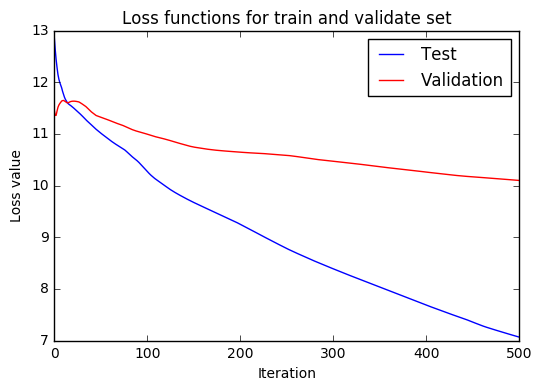

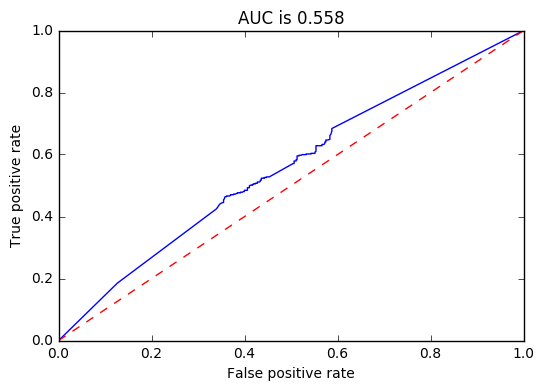

In [70]:
def plot_roc_curve(tpr, fpr, roc_auc):
    plt.title("AUC is {:.3}".format(roc_auc))
    plt.plot(fpr, tpr, '-')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.plot([0,1],[0,1], '--', color = "r")
    plt.show()

    #Your code here
    
    return

def plot_loss_plot(loss_function_test, loss_function_validate):
    plt.title("Loss functions for train and validate set")
    plt.ylabel("Loss value")
    plt.xlabel("Iteration")
    plt.plot(loss_function_test, label = "Test")
    plt.plot(loss_function_validate, color = "red", label = "Validation")
    plt.legend()
    plt.show()

plot_loss_plot(test_loss, validate_loss)
plot_roc_curve(tpr, fpr, roc_auc)

#plt.plot(dates, values, '-o')
#plt.show()

In [71]:
test_users = df_users_ex["uid"].values
ix = np.in1d(users, test_users).reshape(users.shape)
X_ex = X_dataset[np.where(ix)]
X1_ex = X_ex[:,features_counts > 200]
X1_ex = X1_ex.toarray()

In [72]:
predicted = model.predict_proba(X1_ex)
df_users_ex.columns = [u'uid', u'cls']
df_users_ex['cls'] = predicted
df_users_ex.to_csv(path_or_buf = "result.csv", index = False)